## Importing

In [31]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from UNet_func_of_blocks import build_unet
from keras.utils import normalize
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score
from astropy.io import fits
import glob
import random
import scipy.io as sio
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.measure import label, regionprops
from skimage import measure
import joblib

In [32]:
tf.__version__
tf.device('/GPU: 0')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)


# Check for GPU availability
if tf.test.gpu_device_name():
    print('GPU found')
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU found. Make sure TensorFlow GPU version is installed.")


tf.keras.backend.clear_session()

Num GPUs Available:  1
TensorFlow version: 2.17.0
GPU found
Default GPU Device: /device:GPU:0


I0000 00:00:1738964291.457088    6941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738964291.460808    6941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738964291.462672    6941 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1738964291.464464    6941 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# Adjustables

In [33]:
num_epochs = 3
learning_rate = 1e-4
batch_size = 8
seed=24

# Creat the MODELS folder

In [34]:
# Create the folder name
folder_name = f'MODELS_Emask_{num_epochs}_epochs'

# Check if the folder already exists, if not, create it
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully.")
else:
    print(f"Folder '{folder_name}' already exists.")


Folder 'MODELS_Emask_3_epochs' created successfully.


# DATASET Directory 

In [35]:
parent_dir = os.getcwd()

img_dir = f"{parent_dir}/NewImages/GONG/"
stereo_dir = f"{parent_dir}/NewImages/EUV/"
mask_dir = f"{parent_dir}/NewMasks/EUV/"

file_pattern = '*.fits'

## List all the fits files

In [36]:
fits_files = [file for file in os.listdir(img_dir) if file.endswith(".fits")]
fits_files = sorted(fits_files)

#print(fits_files)

# Dataset Prep

In [37]:
# # create empty lists 
image_stack = []
mask_stack = []
stereo_stack = []

# get all the files in the directory
file_paths_stereo = glob.glob(stereo_dir + file_pattern)
file_paths_image = glob.glob(img_dir + file_pattern)
file_paths_mask = glob.glob(mask_dir + file_pattern)

file_paths_stereo.sort()
file_paths_image.sort()
file_paths_mask.sort()

# load in the image data
for file_path in file_paths_image:
    data = fits.getdata(file_path)
    image_stack.append(data)

# load in the mask data
for file_path in file_paths_mask:
    data = fits.getdata(file_path)
    mask_stack.append(data)

# load in the STEREO data
for file_path in file_paths_stereo:
    data = fits.getdata(file_path)
    stereo_stack.append(data)
    
stereo_stack = np.array(stereo_stack)
image_stack = np.array(image_stack)
mask_stack = np.array(mask_stack)

if mask_stack.shape == image_stack.shape:
    print("Image and mask stacks have the same shape")
else:
    exit("Image and mask stacks do not have the same shape")

# reduce the image dimensions
image_stack = image_stack.reshape(-1, image_stack.shape[1], image_stack.shape[2])
mask_stack = mask_stack.reshape(-1, mask_stack.shape[1], mask_stack.shape[2])
stereo_stack = stereo_stack.reshape(-1, stereo_stack.shape[1], stereo_stack.shape[2])

#add channel dimension
stereo_stack = np.expand_dims(stereo_stack, axis=-1)
image_stack = np.expand_dims(image_stack, axis=-1)
mask_stack  = np.expand_dims(mask_stack, axis=-1)

indices = np.arange(len(image_stack))
X_train_indices, X_test_indices, y_train, y_test = train_test_split(indices, mask_stack, test_size=0.25, random_state=42)

# Use the indices to access the data 
X_train = image_stack[X_train_indices]
X_test = image_stack[X_test_indices]

stereo_train = stereo_stack[X_train_indices]
stereo_test = stereo_stack[X_test_indices]

print(f"{len(image_stack)} images total")
print(f"{len(mask_stack)} masks loaded")
print(f"{len(stereo_stack)} stereo loaded")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

Image and mask stacks have the same shape
2381 images total
2381 masks loaded
2381 stereo loaded
X_train shape: (1785, 256, 256, 1)
X_test shape: (596, 256, 256, 1)


In [38]:
# Save the training and testing indicies
np.save(f"{folder_name}/train_indices.npy", X_train_indices)
np.save(f"{folder_name}/test_indices.npy", X_test_indices)

print(f"Train indices saved to {folder_name}/train_indices.npy")
print(f"Test indices saved to {folder_name}/test_indices.npy")

Train indices saved to MODELS_Emask_3_epochs/train_indices.npy
Test indices saved to MODELS_Emask_3_epochs/test_indices.npy


In [39]:
FitsFiles_train = [fits_files[i] for i in X_train_indices]
FitsFiles_test = [fits_files[i] for i in X_test_indices]

# Visualize a sample

842


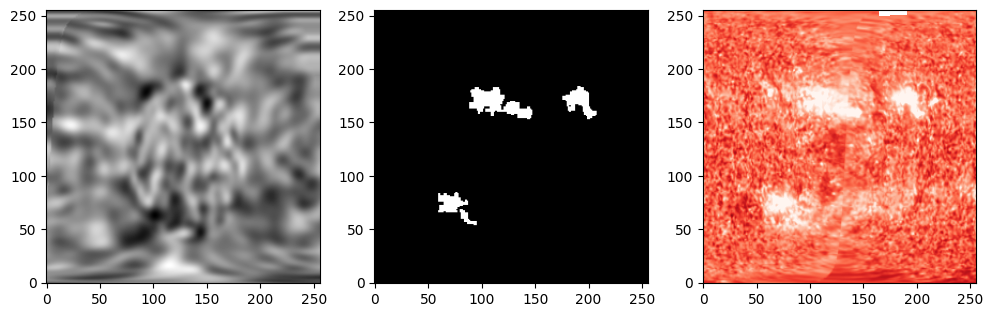

GONG20110730t1200.fits


In [40]:
image_number = random.randint(0, len(X_train))
print(image_number)

plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.imshow(X_train[image_number,:,:], cmap='gray', origin='lower')
plt.subplot(132)
plt.imshow(y_train[image_number,:,:], cmap='gray', origin='lower')
plt.subplot(133)
plt.imshow(stereo_train[image_number,:,:], cmap='Reds_r', origin='lower')
plt.clim(-3, 3)
plt.show()
print(FitsFiles_train[image_number])

# DATASET Augmentations

In [41]:
# Custom function for exact rotations at 90, 180, and 270 degrees
def rotate_image(image):
    angle = random.choice([90, 180, 270])
    return np.rot90(image, k=angle // 90)  # Rotates image by multiples of 90 degrees

# Define the augmentation parameters without random rotation
img_data_gen_args = dict(horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect',
                         preprocessing_function=rotate_image)

mask_data_gen_args = dict(horizontal_flip=True,
                          vertical_flip=True,
                          fill_mode='reflect',
                          preprocessing_function=lambda x: np.where(rotate_image(x) > 0, 1, 0).astype(x.dtype))  # Binarize after rotating

# Define the image generator
image_data_generator = ImageDataGenerator(**img_data_gen_args)
mask_data_generator = ImageDataGenerator(**mask_data_gen_args)

# Image and mask generators
image_generator = image_data_generator.flow(X_train, seed=seed, batch_size=batch_size)
valid_img_generator = image_data_generator.flow(X_test, seed=seed, batch_size=batch_size)

mask_generator = mask_data_generator.flow(y_train, seed=seed, batch_size=batch_size)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed, batch_size=batch_size)

# Combine image and mask generators
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)
validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

## TEST plot

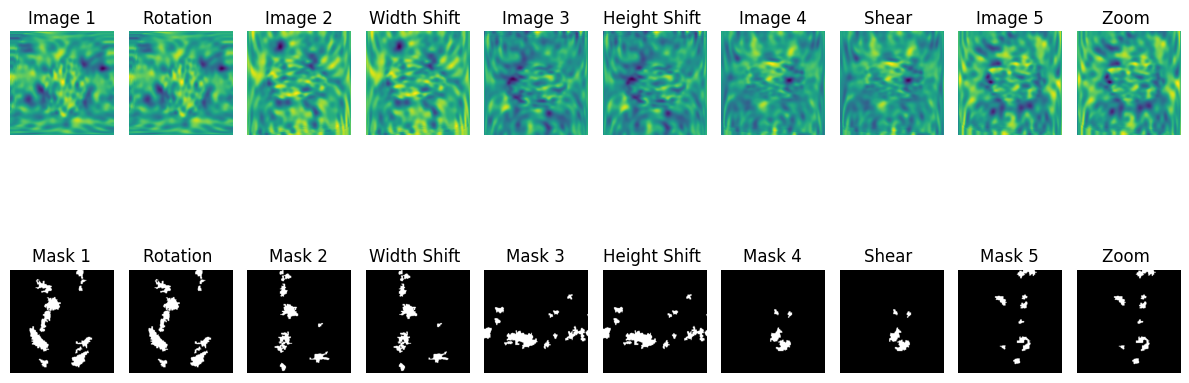

In [42]:
num_images = 5

augmentation_processes = [
    'Original', 'Rotation', 'Width Shift', 'Height Shift', 'Shear', 
    'Zoom', 'Horizontal Flip', 'Vertical Flip'
]

fig, axs = plt.subplots(nrows=2, ncols=num_images*2, figsize=(12, 6))

for i in range(num_images):
    augmented_img, augmented_mask = next(my_generator)
    
    # Plot original image
    axs[0, 2*i].imshow(augmented_img[0])  # Assuming batch_size=1
    axs[0, 2*i].set_title(f'Image {i+1}')
    axs[0, 2*i].axis('off')
    
    # Plot corresponding augmented image
    axs[0, 2*i+1].imshow(augmented_img[0])  # Assuming batch_size=1
    axs[0, 2*i+1].set_title(f'{augmentation_processes[i+1]} ')
    axs[0, 2*i+1].axis('off')
    
    # Plot original mask
    axs[1, 2*i].imshow(augmented_mask[0, :, :, 0], cmap='gray')  # Assuming batch_size=1
    axs[1, 2*i].set_title(f'Mask {i+1}')
    axs[1, 2*i].axis('off')
    
    # Plot corresponding augmented mask
    axs[1, 2*i+1].imshow(augmented_mask[0, :, :, 0], cmap='gray')  # Assuming batch_size=1
    axs[1, 2*i+1].set_title(f'{augmentation_processes[i+1]} ')
    axs[1, 2*i+1].axis('off')

plt.tight_layout()
plt.show()


## Estimated total augmented images

In [43]:
N = len(X_train)  
augmentations_per_image = 7  # 1 original + 2 flips * 3 rotations

total_augmented_images = N * augmentations_per_image
total_augmented_masks = N * augmentations_per_image

print(f"Original number of images: {N}")
print(f"Total unique augmented images: {total_augmented_images}")
print(f"Total unique augmented masks: {total_augmented_masks}")

steps_per_epoch = 3*(len(X_train))//batch_size

Original number of images: 1785
Total unique augmented images: 12495
Total unique augmented masks: 12495


# Initialize the model

In [44]:
IMG_HEIGHT = image_stack.shape[1]
IMG_WIDTH  = image_stack.shape[2]
IMG_CHANNELS = image_stack.shape[3]


input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

model = build_unet(input_shape)

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['binary_accuracy'])


model.summary()

## Define the checkpoint callback to save the model at each epoch
checkpoint_filepath = os.path.join(folder_name, 'model_checkpoint_epoch_{epoch:02d}.h5.keras')

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=False,  # Set to True to only save the best model
    save_freq='epoch'
)

# Train the model with the checkpoint callback
history = model.fit(
    my_generator, 
    validation_data=validation_datagen, 
    steps_per_epoch=steps_per_epoch, 
    validation_steps=steps_per_epoch, 
    epochs=num_epochs,
    callbacks=[model_checkpoint_callback]
)


Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 64, 64,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 84s 119ms/step - binary_accuracy: 0.9525 - loss: 0.2454 - val_binary_accuracy: 0.9566 - val_loss: 0.1595
Epoch 2/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 77s 116ms/step - binary_accuracy: 0.9569 - loss: 0.1598 - val_binary_accuracy: 0.9566 - val_loss: 0.1594
Epoch 3/3
669/669 ━━━━━━━━━━━━━━━━━━━━ 76s 114ms/step - binary_accuracy: 0.9568 - loss: 0.1594 - val_binary_accuracy: 0.9566 - val_loss: 0.1615


## Save the model weights at the same location as the checkpoint

In [45]:
weights_filepath = os.path.join(folder_name, 'FASTARR_E.weights.h5')
model.save_weights(weights_filepath)

# Training and validation accuracy and loss at each epoc

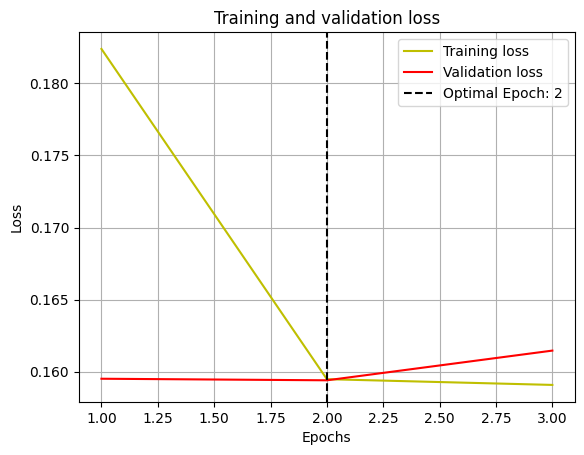

The optimal number of epochs is: 2
The index of the optimal epoch is: 1
Training history saved to MODELS_Emask_3_epochs/training_history.mat


In [46]:
# Find the epoch with the minimum validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

optimal_epoch_index = np.argmin(val_loss)
optimal_epoch = optimal_epoch_index + 1  # Plus 1 bcz epochs are 1-based

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')

plt.axvline(x=optimal_epoch, color='k', linestyle='--', label=f'Optimal Epoch: {optimal_epoch}')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)  # Add grid
plt.legend()
plt.savefig(os.path.join(folder_name, 'training_loss_plot.png'))  

plt.show()

print(f'The optimal number of epochs is: {optimal_epoch}')
print(f'The index of the optimal epoch is: {optimal_epoch_index}')

# Save the 'epochs', 'loss', and 'val_loss' to a .mat file
mat_filepath = os.path.join(folder_name, 'training_history.mat')

training_data = {
    'epochs': epochs,
    'loss': loss,
    'val_loss': val_loss,
    'optimal_epoch': optimal_epoch
}

sio.savemat(mat_filepath, training_data)
print(f"Training history saved to {mat_filepath}")

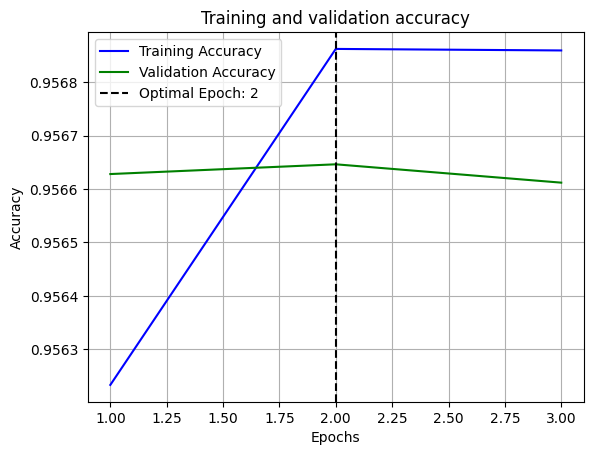

Training history saved to MODELS_Emask_3_epochs/accuracy_history.mat


In [47]:
accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']

epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation Accuracy')
plt.axvline(x=optimal_epoch, color='k', linestyle='--', label=f'Optimal Epoch: {optimal_epoch}')

plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(folder_name, 'training_accuracy_plot.png'))  

plt.show()

# Save the 'accuracy', 'val_accuracy', and 'epochs' to a .mat file
accuracy_mat_filepath = os.path.join(folder_name, 'accuracy_history.mat')

accuracy_data = {
    'epochs': epochs,
    'accuracy': accuracy,
    'val_accuracy': val_accuracy,
    'optimal_epoch': optimal_epoch
}

sio.savemat(accuracy_mat_filepath, accuracy_data)
print(f"Training history saved to {accuracy_mat_filepath}")

In [48]:
# Inspect the history.history keys
print(history.history.keys())

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step
IoU score is:  0.10176647991905925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
GONG20130901t0000.fits


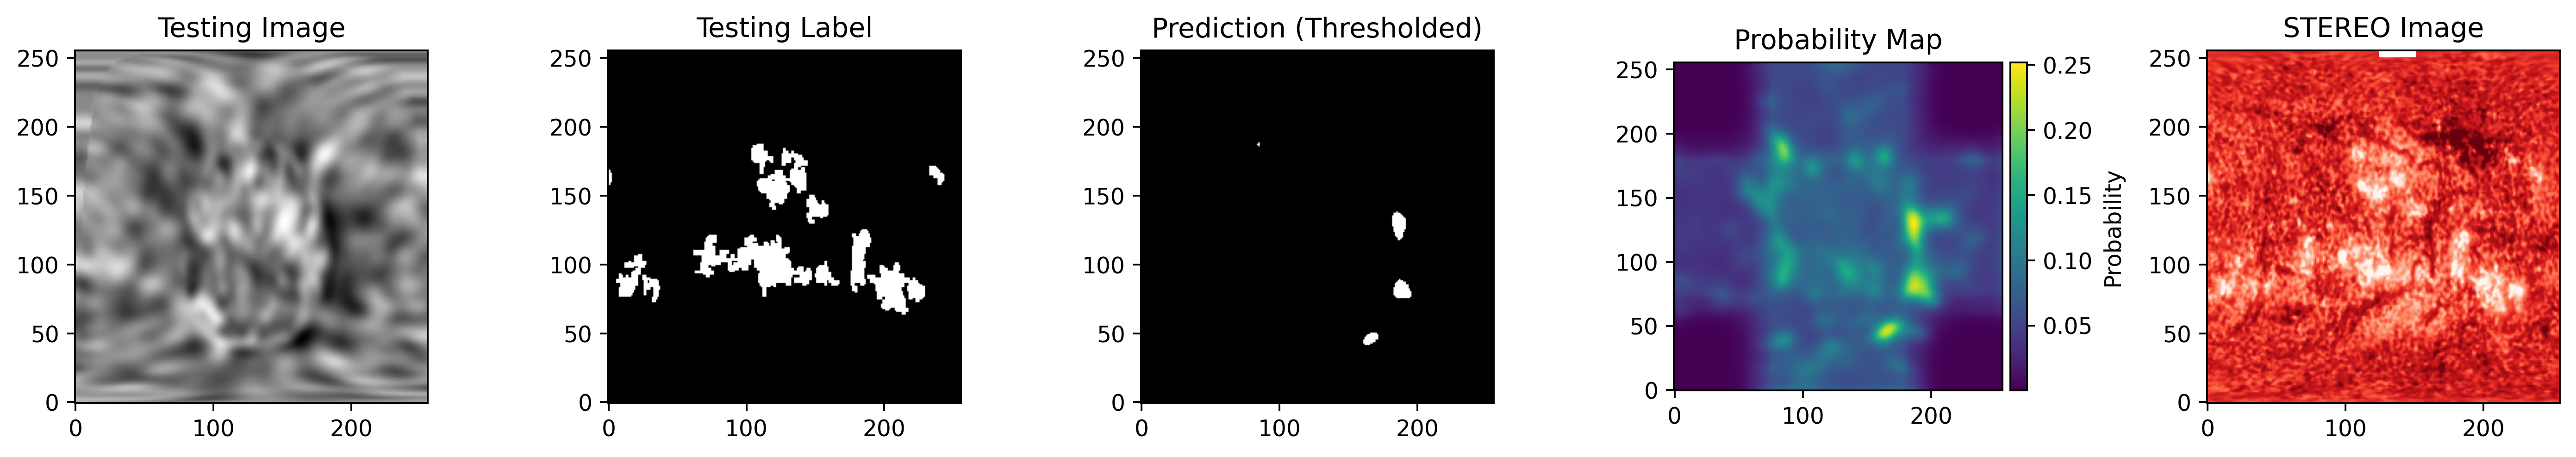

In [49]:
prop_threshold = 0.20

y_pred = model.predict(X_test)  
y_pred_thresholded = y_pred > prop_threshold  

# IoU
intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is: ", iou_score)

test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
stereo_img = stereo_test[test_img_number]
ground_truth = y_test[test_img_number]

test_img_norm = test_img[:, :, 0][:, :, None]
test_img_input = np.expand_dims(test_img_norm, 0)

probability_map = model.predict(test_img_input)[0, :, :, 0]


################# Apply threshold to get binary prediction ##################
prediction = (probability_map > prop_threshold).astype(np.uint8)

fig = plt.figure(figsize=(16, 8), dpi=350)
gs = GridSpec(1, 5, figure=fig)

# Original Test Image
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title('Testing Image')
ax1.imshow(test_img[:, :, 0], cmap='gray', origin='lower')

# Ground Truth Label
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title('Testing Label')
ax2.imshow(ground_truth[:, :, 0], cmap='gray', origin='lower')

# Prediction after Thresholding
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title('Prediction (Thresholded)')
ax3.imshow(prediction, cmap='gray', origin='lower')

# Probability Map 
ax4 = fig.add_subplot(gs[0, 3])
ax4.set_title('Probability Map')
im = ax4.imshow(probability_map, cmap='viridis', origin='lower')

divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.05)  
fig.colorbar(im, cax=cax, label='Probability')

# STEREO Image
ax5 = fig.add_subplot(gs[0, 4])
ax5.set_title('STEREO Image')
stereo = ax5.imshow(stereo_img, cmap='Reds_r', origin='lower')
stereo.set_clim(-2, 4)  

plt.tight_layout()

print(FitsFiles_test[test_img_number])

file_name = f"{FitsFiles_test[test_img_number]}_example2.png"  
plt.savefig(f'{folder_name}/{file_name}', bbox_inches='tight') 
plt.show()


## Dice Loss

In [50]:
prediction = np.expand_dims(prediction, axis=-1)  # Add a new dimension

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    intersection = np.sum(y_true * y_pred)  # Intersection
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    return (2. * intersection + smooth) / (true_sum + pred_sum + smooth)


def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)


dice_coeff = dice_coefficient(ground_truth, prediction)
loss = dice_loss(ground_truth, prediction)

print("Dice Coefficient:", dice_coeff)
print("Dice Loss:", loss)

Dice Coefficient: 0.02091967653030991
Dice Loss: 0.9790803234696901


## Plot the ROC Curve


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


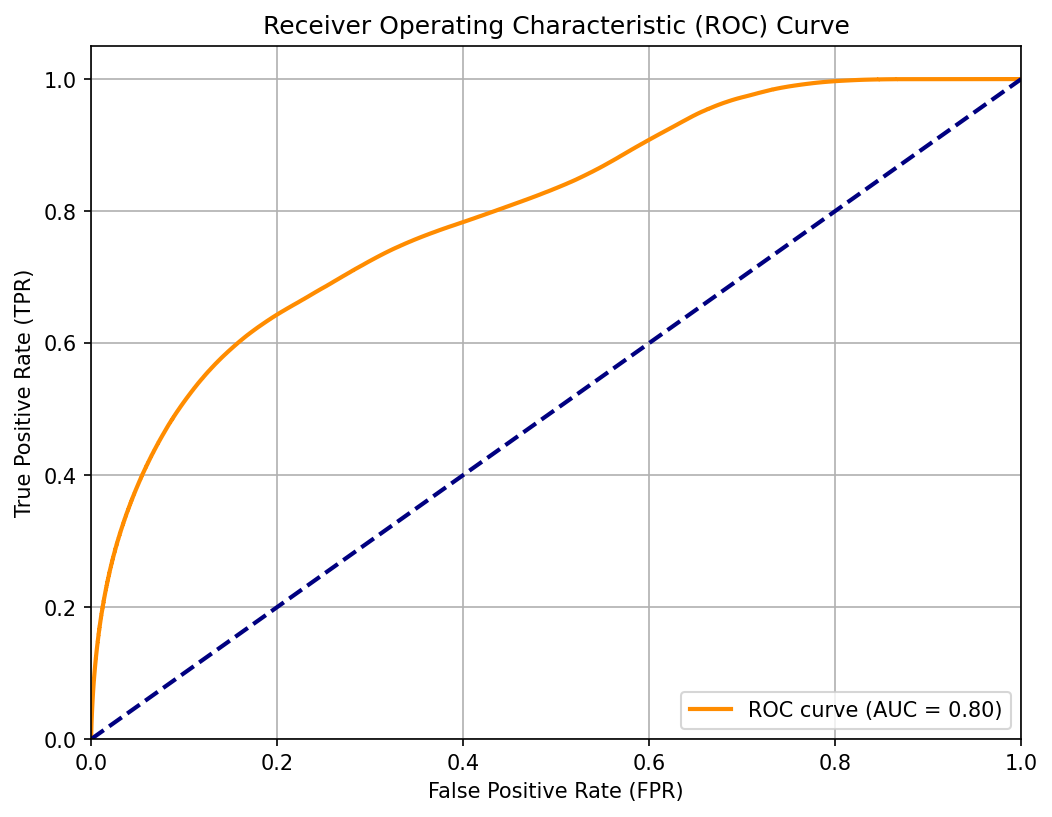

Training history saved to MODELS_Emask_3_epochs/ROC_curve.mat


In [51]:
y_pred = model.predict(X_test)  
y_pred_flat = y_pred.flatten()  
y_test_flat = y_test.flatten()
fpr, tpr, thresholds = roc_curve(y_test_flat, y_pred_flat)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(folder_name, 'ROC_plot.png'))  
plt.show()

ROC_mat_filepath = os.path.join(folder_name, 'ROC_curve.mat')
ROC_data = {
    'fpr': fpr,
    'tpr': tpr,
    'AUC': roc_auc
}
sio.savemat(ROC_mat_filepath, ROC_data)

print(f"Training history saved to {ROC_mat_filepath}")

## the Precision-Recall Curve   

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


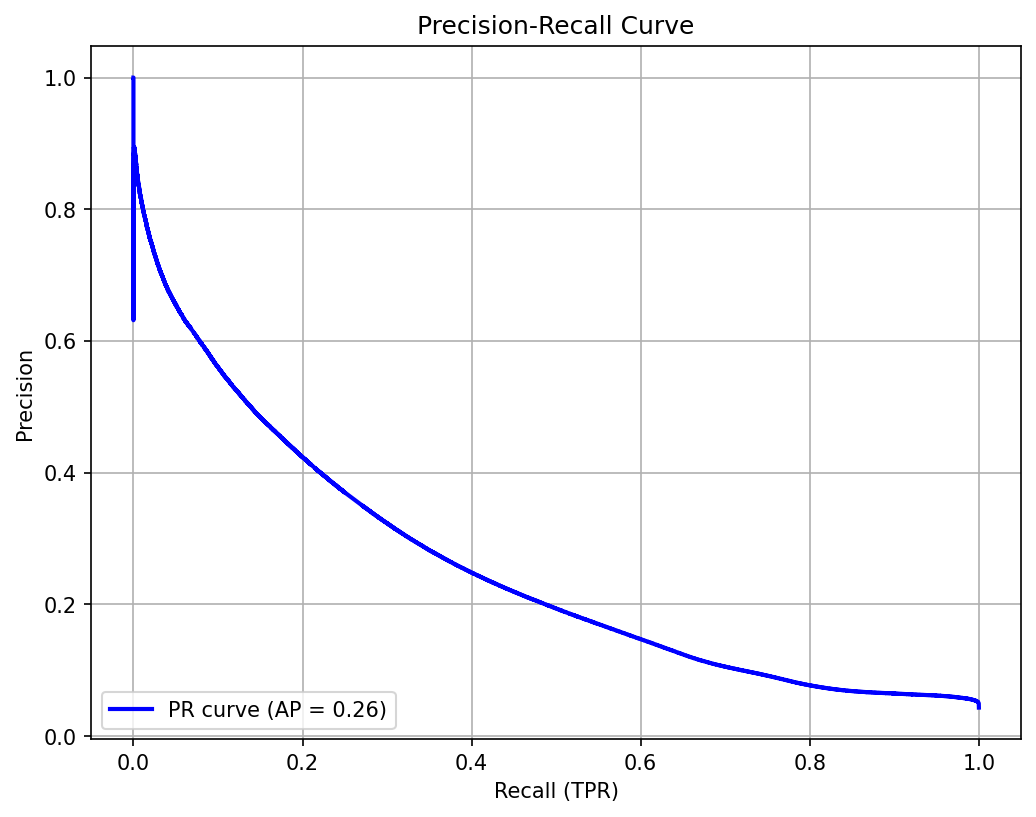

Training history saved to MODELS_Emask_3_epochs/Rprecision_recall_curve.mat


In [52]:
y_pred = model.predict(X_test) 
y_pred_flat = y_pred.flatten()  

y_test_flat = y_test.flatten()

# Precision-Recall curve and Average Precision (AP) score
precision, recall, thresholds = precision_recall_curve(y_test_flat, y_pred_flat)
average_precision = average_precision_score(y_test_flat, y_pred_flat)

plt.figure(figsize=(8, 6), dpi=150)
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.2f})')
plt.xlabel('Recall (TPR)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.savefig(os.path.join(folder_name, 'PR_plot.png'))  
plt.show()

precision_recall_curve_mat_filepath = os.path.join(folder_name, 'Rprecision_recall_curve.mat')
precision_recall_data = {
    'recall': recall,
    'precision': precision,
    'AP': average_precision
}
sio.savemat(precision_recall_curve_mat_filepath, precision_recall_data)

print(f"Training history saved to {precision_recall_curve_mat_filepath}")

## Evaluation metrices

In [53]:
results = model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - binary_accuracy: 0.9568 - loss: 0.1538
Loss: 0.15408943593502045
Accuracy: 0.9566219449043274


In [54]:
def iou_metric(y_test, y_pred):
    y_test = tf.cast(y_test, tf.float32)
    y_pred = tf.cast(y_pred > 0.2, tf.float32)
    intersection = tf.reduce_sum(y_test * y_pred)
    union = tf.reduce_sum(y_test) + tf.reduce_sum(y_pred) - intersection
    return intersection / union

model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=['accuracy', iou_metric])

# Evaluate the model again
results = model.evaluate(X_test, y_test, verbose=1)

print(f"Loss: {results[0]}")
print(f"Accuracy: {results[1]}")
print(f"IoU: {results[2]}")


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.9568 - iou_metric: 0.0972 - loss: 0.1538
Loss: 0.15408943593502045
Accuracy: 0.9566219449043274
IoU: 0.10213259607553482


# BOX the isolated segments [prediction and Ground_Truth]

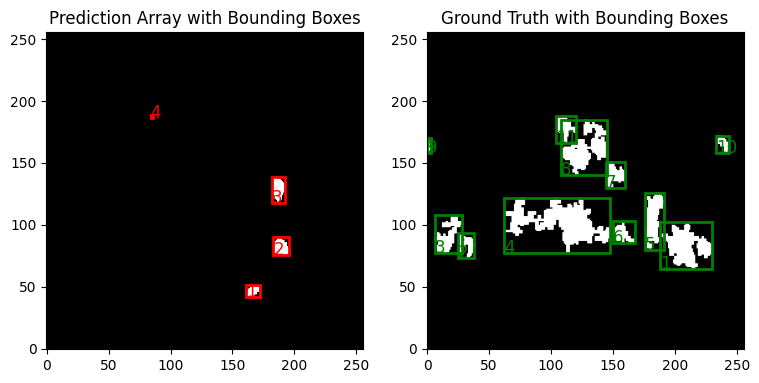

In [55]:
labeled_prediction = label(prediction[:, :, 0])  
regions_prediction = regionprops(labeled_prediction)  

labeled_ground_truth = label(ground_truth[:, :, 0])  
regions_ground_truth = regionprops(labeled_ground_truth)  

fig, ax = plt.subplots(1, 2, figsize=(9, 9))  

ax[0].imshow(prediction[:, :, 0], cmap='gray', origin='lower')  
for region in regions_prediction:
    if len(region.bbox) == 4:  
        min_row, min_col, max_row, max_col = region.bbox
        rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                             fill=False, edgecolor='red', linewidth=2)
        ax[0].add_patch(rect)
        region_number = region.label
        ax[0].text(min_col, min_row, str(region_number), color='red', fontsize=12)

ax[0].set_title('Prediction Array with Bounding Boxes')

ax[1].imshow(ground_truth[:, :, 0], cmap='gray', origin='lower')  
for region in regions_ground_truth:
    if len(region.bbox) == 4:  
        min_row, min_col, max_row, max_col = region.bbox
        rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                             fill=False, edgecolor='green', linewidth=2)
        ax[1].add_patch(rect)
        region_ground_truth_number = region.label
        ax[1].text(min_col, min_row, str(region_ground_truth_number), color='green', fontsize=12)

ax[1].set_title('Ground Truth with Bounding Boxes')
plt.show()


## Filter out regions [prediction]


Number of connected regions: 3


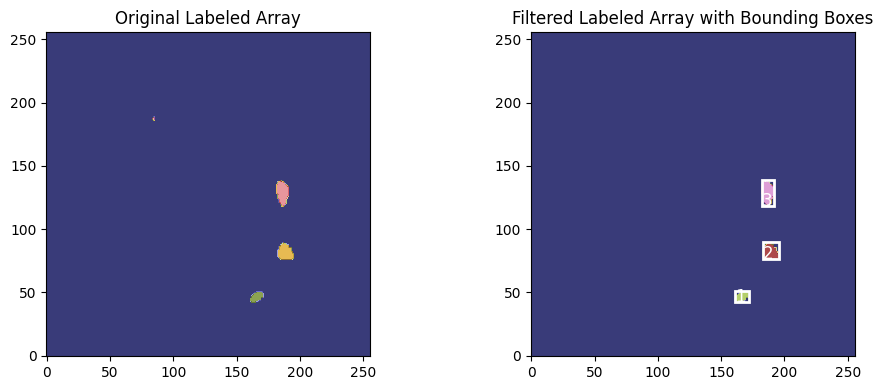

In [56]:
# Filter out regions with an area less than 50 pixels
filtered_regions = [region for region in regionprops(labeled_prediction) if region.area >= 50]

# Create a new labeled array with only the filtered regions
filtered_labeled_prediction = np.zeros_like(labeled_prediction)
for region in filtered_regions:
    filtered_labeled_prediction[labeled_prediction == region.label] = region.label

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(labeled_prediction, cmap='tab20b', origin='lower')
plt.title("Original Labeled Array")

plt.subplot(1, 2, 2)
plt.imshow(filtered_labeled_prediction, cmap='tab20b', origin='lower')  
plt.title("Filtered Labeled Array with Bounding Boxes")

labeled_filtered = label(filtered_labeled_prediction)  
regions_filtered = regionprops(labeled_filtered)  

for region in regions_filtered:
    if len(region.bbox) == 4:  
        min_row, min_col, max_row, max_col = region.bbox
        rect = plt.Rectangle((min_col, min_row), max_col - min_col, max_row - min_row,
                             fill=False, edgecolor='white', linewidth=2)
        plt.gca().add_patch(rect)
        regions_filtered_number = region.label
        plt.text(min_col, min_row, str(regions_filtered_number), color='white', fontsize=12)

num_connected_regions = len(regions_filtered)
print(f"Number of connected regions: {num_connected_regions}")

plt.tight_layout()
plt.show()


# Getting each region's (1) coordinate, (2) %Area, (3) Min.Phase_value, and (4) PS


In [57]:
# Calculate total image area (total number of pixels)
total_image_area = prediction.size

# Open a text file for writing
with open('region_info.txt', 'w') as file:
    for region in regions_filtered:
        
        region_indices = region.coords  # Get the indices of the region
        AA = test_img[region_indices]
        min_value = np.min(AA)
        
        region_area = region.area
        area_ratio = (region_area / total_image_area)*100
        rounded_centroid = tuple(map(round, region.centroid))
        rounded_perimeter = round(region.perimeter)

        print(f"Region Label: {region.label}")
        print(f"min. phase shift value: {min_value}")
        print(f"Centroid: {rounded_centroid}")          
        print(f"Area: {region.area}")
        print(f"%-Area Ratio: {area_ratio:.4f}")  # Print with FOUR decimal places
        #print(f"Bounding Box: {region.bbox}")
        print(f"Perimeter: {rounded_perimeter}")
        print("\n")
    
     # Write region information to the file
        file.write(f"Region Label: {region.label}\n")
        file.write(f"Centroid: {rounded_centroid}\n")
        file.write(f"min. phase shift value: {min_value}\n")
        file.write(f"Area: {region.area}\n")
        file.write(f"%-Area Ratio: {area_ratio:.4f}\n")  # Print with FOUR decimal places
        file.write(f"Perimeter: {rounded_perimeter}\n")
        file.write("\n")

Region Label: 1
min. phase shift value: -0.14838555277059465
Centroid: (46, 166)
Area: 71.0
%-Area Ratio: 0.1083
Perimeter: 31


Region Label: 2
min. phase shift value: -0.1234422327165031
Centroid: (81, 189)
Area: 136.0
%-Area Ratio: 0.2075
Perimeter: 43


Region Label: 3
min. phase shift value: -0.1371780703008002
Centroid: (129, 186)
Area: 151.0
%-Area Ratio: 0.2304
Perimeter: 49




## IMAGE Edging

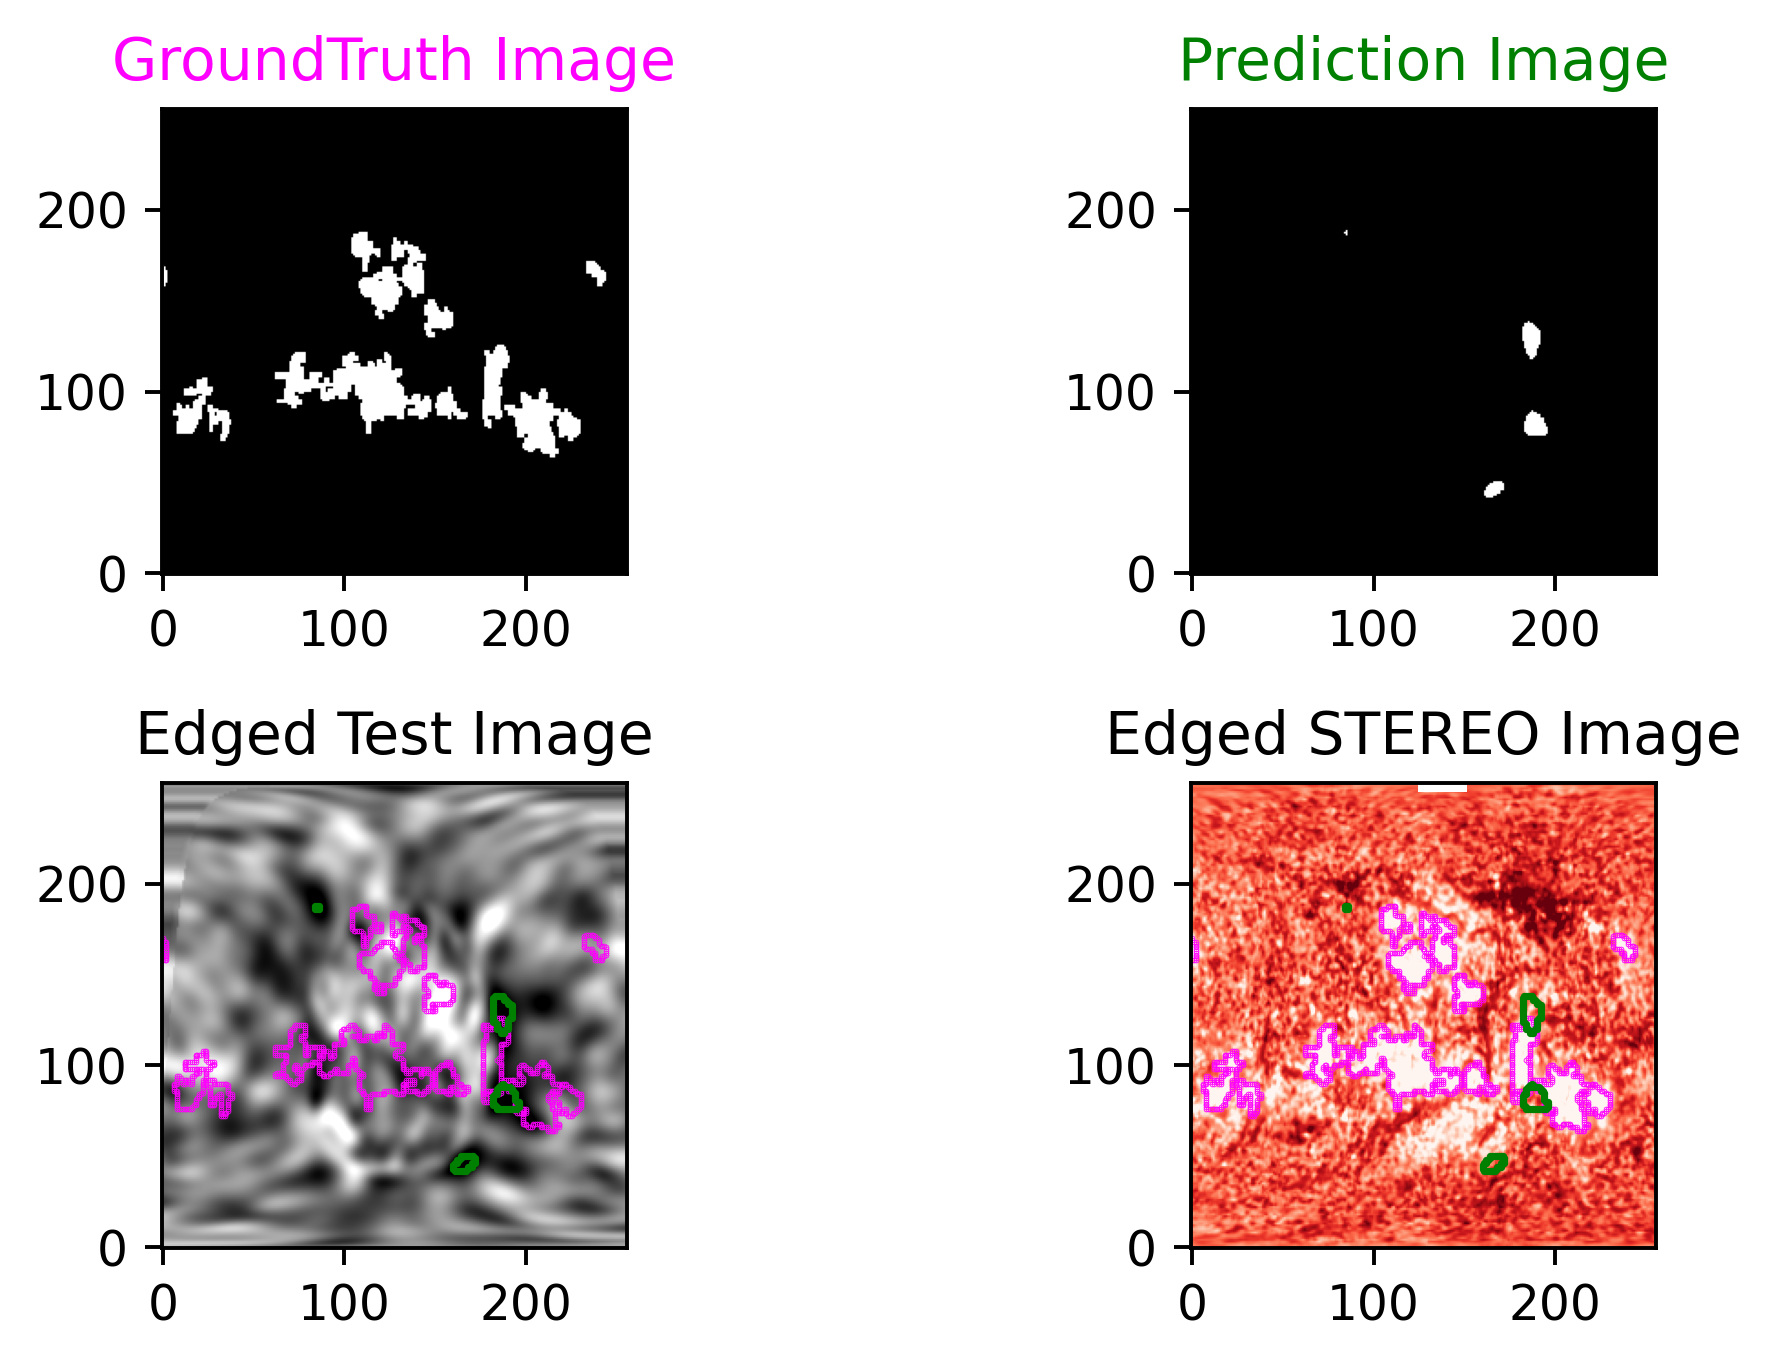

In [58]:
# Extract edges of each region
edge_prediction = np.zeros_like(labeled_prediction, dtype=np.uint8)
for label in range(1, labeled_prediction.max() + 1):
    mask = (labeled_prediction == label)
    perimeter = measure.find_contours(mask.astype(float), 0.5)[0]
    perimeter = np.round(perimeter).astype(int)
    edge_prediction[perimeter[:, 0], perimeter[:, 1]] = label


edge_GroundTruth = np.zeros_like(labeled_ground_truth, dtype=np.uint8)
for label in range(1, labeled_ground_truth.max() + 1):
    mask = (labeled_ground_truth == label)
    perimeter_GT = measure.find_contours(mask.astype(float), 0.5)[0]
    perimeter_GT = np.round(perimeter_GT).astype(int)
    edge_GroundTruth[perimeter_GT[:, 0], perimeter_GT[:, 1]] = label

# Mask the edges on the test image
masked_test_img = test_img.copy()
masked_stereo_img = stereo_img.copy()

# Display the results
plt.figure(figsize=(10, 4), dpi=350)

plt.subplot(221)
plt.imshow(ground_truth[:,:,0], cmap='gray', origin='lower')
plt.title("GroundTruth Image", color='magenta')

plt.subplot(222)
plt.imshow(prediction, cmap='gray', origin='lower')
plt.title("Prediction Image", color='green')

plt.subplot(223)
plt.imshow(test_img, cmap='gray', origin='lower')
plt.title("Edged Test Image")
plt.clim(-0.1, 0.1)
edge_coords2 = np.argwhere(edge_GroundTruth) # Scatter the edges using green color
plt.scatter(edge_coords2[:, 1], edge_coords2[:, 0], color='magenta', s=0.1, marker='.')

edge_coords = np.argwhere(edge_prediction) # Scatter the edges using green color
plt.scatter(edge_coords[:, 1], edge_coords[:, 0], color='green', s=1, marker='.')

plt.subplot(224)
plt.imshow(masked_stereo_img, cmap='Reds_r', origin='lower')
plt.title("Edged STEREO Image")
plt.clim(-2, 2)
edge_coords2 = np.argwhere(edge_GroundTruth) # Scatter the edges using green color
plt.scatter(edge_coords2[:, 1], edge_coords2[:, 0], color='magenta', s=0.1, marker='.')

edge_coords = np.argwhere(edge_prediction) # Scatter the edges using green color
plt.scatter(edge_coords[:, 1], edge_coords[:, 0], color='green', s=1, marker='.')



plt.tight_layout(w_pad=1)  # Adjust w_pad for horizontal spacing
plt.tight_layout()
plt.show()


## Saving

In [59]:
# Save the entire workspace
workspace_variables = {k: v for k, v in globals().items() if not k.startswith('__') and k not in ['os', 'joblib']}

def is_serializable(obj):
    try:
        joblib.dumps(obj)
        return True
    except:
        return False

FASTARR_E_workspace = {k: v for k, v in globals().items() if not k.startswith('__') and is_serializable(v)}

workspace_file_path = os.path.join(folder_name, "FASTARR_E_workspace.pkl")

joblib.dump(FASTARR_E_workspace, workspace_file_path)

print(f"Workspace variables saved to {workspace_file_path}")

Workspace variables saved to MODELS_Emask_3_epochs/FASTARR_E_workspace.pkl
